# Antutu benchmark on Android

The goal of this experiment is to run benchmarks on a hikey960 board running Android with an IPA kernel and collect results. The analysis phase will consist in comparing IPA summary with:
    
The benchmark we will be using is ***Antutu 3Dbench*** (http://www.antutu.com/en). You will need to **manually install** the app on the Android device in order to run this Notebook.

the goals of this notebook:
1. Check different thermal behaviour for different pid coefficient
1. Compare the real power usage of SOC for different pid coefficient

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2018-05-07 16:46:03,347 INFO    : root         : Using LISA logging configuration:
2018-05-07 16:46:03,348 INFO    : root         :   /home/steven/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import copy
import os
from time import sleep
from subprocess import Popen
import pandas as pd

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID. Also, you have to specify the path to your android sdk in ANDROID_HOME.

In [3]:
# Setup a target configuration
my_target_conf = {
    
#     # Target platform and board
#     "platform"    : 'android',

#     # Add target support
#     "board" : 'pixel',
    
#     # Device ID
#     "device" : "HT6670300102",
    
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/steven/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "cpu_capacity",
            "cpu_frequency",
            "thermal_power_devfreq_limit",
            "thermal_power_devfreq_get_power",
            "thermal_power_cpu_limit",
            "thermal_power_cpu_get_power",
            "thermal_zone_trip",
            "cdev_update",
            "thermal_temperature",
            "thermal_power_allocator_pid",
            "thermal_power_allocator",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
    
    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],
}

In [4]:
my_tests_conf = {

    # Folder where all the results will be collected
    "results_dir" : "Android_Antutu3_pid",

    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "antutu",
            "flags"          : "ftrace",           # Enable FTrace events
            "sched_features" : "ENERGY_AWARE",     # enable EAS
        },
    ],
}

In [5]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-05-07 16:46:06,466 INFO    : TestEnv      : Using base path: /home/steven/lisa/lisa-github
2018-05-07 16:46:06,468 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-05-07 16:46:06,470 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-05-07 16:46:06,472 INFO    : TestEnv      : External tools using:
2018-05-07 16:46:06,474 INFO    : TestEnv      :    ANDROID_HOME: /home/steven/lisa/android-sdk
2018-05-07 16:46:06,475 INFO    : TestEnv      :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
2018-05-07 16:46:06,476 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2018-05-07 16:46:06,478 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2018-05-07 16:46:06,479 INFO    : TestEnv      : Connection settings:
2018-05-07 16:46:06,480 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2018-05-07 16:46:08,348 INFO    : TestEnv      : Initializing target workdir:
2018-05-07 1

## Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [6]:
def wait_for_cooling():
    print "wait for cooling"
    while True:
        temp=target.read_int('/sys/class/thermal/thermal_zone0/temp')
        print temp
        if temp < 48000:
            break
        sleep(5)
    print "cooling done, start test"

In [7]:
kp_origin=target.read_int('/sys/class/thermal/thermal_zone0/k_pu')

def set_test1():
    wait_for_cooling()
    target.execute('echo 921 > /sys/class/thermal/thermal_zone0/k_pu')
    print target.read_int('/sys/class/thermal/thermal_zone0/k_pu')

def set_test2():
    wait_for_cooling()
    kp2=kp_origin*2/3
    target.execute('echo {} > /sys/class/thermal/thermal_zone0/k_pu'.format(kp2))
    print target.read_value('/sys/class/thermal/thermal_zone0/k_pu')
    
def set_test3():
    wait_for_cooling()
    kp3=kp_origin*4/3
    target.execute('echo {} > /sys/class/thermal/thermal_zone0/k_pu'.format(kp3))
    print target.read_value('/sys/class/thermal/thermal_zone0/k_pu')

In [8]:
# CPUFreq configurations to test
confs = {
#     'performance' : {
#         'label' : 'prf',
#         'set' :  set_performance,
#     },
    #'powersave' : {
    #    'label' : 'pws',
    #    'set' :  set_powersave,
    #},
#      'interactive' : {
#          'label' : 'int',
#          'set' :  set_interactive,
#      },
    'test1' : {
       'label' : 'test1',
       'set' :  set_test1,
    },
    'test2' : {
       'label' : 'test2',
       'set' :  set_test2,
    },
    'test3' : {
       'label' : 'test3',
       'set' :  set_test3,
    },
    #'ondemand' : {
    #    'label' : 'odm',
    #    'set' :  set_ondemand,
    #}
}

# The set of results for each comparison test
results = {}

In [9]:
#Check if PCMark si available on the device

def check_packages(pkgname):
    try:
        output = target.execute('pm list packages -f | grep -i {}'.format(pkgname))
    except Exception:
        raise RuntimeError('Package: [{}] not availabe on target'.format(pkgname))

# Check for specified PKG name being available on target
check_packages('com.antutu.ABenchMark')
target.adb_root(force=True)

In [10]:
wait_for_cooling()

wait for cooling
47617
cooling done, start test


In [11]:
from android import Screen

target.execute('am force-stop {}'.format("com.antutu.ABenchMark"))
target.execute('input keyevent 4')
Screen.set_orientation(target, auto=False, portrait=True)
Screen.set_brightness(target, auto=False, percent=0)
target.cpufreq.set_all_governors('schedutil')

# Start PCMark on the target device
#target.execute('monkey --pct-syskeys 0 -p com.antutu.ABenchMark -c android.intent.category.LAUNCHER 1')
# Wait few seconds to make sure the app is loaded
# Screen.set_orientation(target, auto=False, portrait=True)
#sleep(10)
#target.execute('input tap 961 202')
# Wait few seconds to make sure the app is loaded
# sleep(5)
    

# Run performance workload (assume screen is vertical)


2018-05-07 16:46:17,746 INFO    : Screen       : Force manual orientation
2018-05-07 16:46:17,747 INFO    : Screen       : Set orientation: PORTRAIT
2018-05-07 16:46:19,184 INFO    : Screen       : Set brightness: 0%


''

In [12]:
# Function that helps run a Antutu experiment
from android import Screen
from devlib.utils.android import adb_command

def benchmark_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('am force-stop {}'.format("com.antutu.ABenchMark"))
    target.execute('input keyevent 82')
    Screen.set_brightness(target, auto=False, percent=0)

    # Start PCMark on the target device
    target.execute('monkey --pct-syskeys 0 -p com.antutu.ABenchMark  1')
#     Screen.set_orientation(target, auto=False, portrait=True)

    # Wait few seconds to make sure the app is loaded
    sleep(5)
    
    # Flush entire log
    target.clear_logcat()
    target.execute('input tap 860 1000')
    sleep(1)
    Screen.set_orientation(target, auto=False, portrait=True)
    # Run performance workload (assume screen is vertical)
    target.execute('input tap 960 200')
    # Wait for completion (10 minutes in total) and collect log
#     log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    sleep(30)
    # Start collecting the log
#     with open(log_file, 'w') as log:
#         logcat = Popen(['adb logcat', 'com.antutu.ABenchMark.VirtualMachineState:*', '*:S'],
#                        stdout=log,
#                        shell=True)
#         # Wait additional two minutes for benchmark to complete
#         sleep(300)

#         # Terminate logcat
#         logcat.kill()

#     # Get scores from logcat
#     score_file = os.path.join(exp_dir, 'score.txt')
#     os.popen('grep -o ".*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application
    adb_command(target.adb_name, 'shell screencap -p /data/local/tmp/screen.png')
    adb_command(target.adb_name, 'pull /data/local/tmp/screen.png {}'.format(te.res_dir))
    target.execute('am force-stop com.antutu.ABenchMark')
    target.execute('am force-stop com.antutu.benchmark.full')

  

In [13]:
# Function that helps run PCMark for different governors

def experiment(governor, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));
    trace_file = os.path.join(exp_dir, 'trace.dat')

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    ### Run the benchmark ###
    te.ftrace.start()

    benchmark_run(exp_dir)
    
    te.ftrace.stop()
    te.ftrace.get_trace(trace_file)

    # return all the experiment data
    return {
        'dir'        : exp_dir,
    }

## Run Antutu and collect scores

In [14]:
# Run the benchmark in all the configured governors
testresult_list=[]
for testname in confs:
    test_dir = os.path.join(te.res_dir, testname)
    res = experiment(testname, test_dir)
    testresult_list.append(test_dir)
    print test_dir

2018-05-07 16:46:23,980 INFO    : root         : ------------------------
2018-05-07 16:46:23,982 INFO    : root         : Run workload using test1 governor


wait for cooling
47822
cooling done, start test
921


2018-05-07 16:46:28,295 INFO    : Screen       : Set brightness: 0%
2018-05-07 16:46:35,257 INFO    : Screen       : Force manual orientation
2018-05-07 16:46:35,259 INFO    : Screen       : Set orientation: PORTRAIT
2018-05-07 16:47:59,382 INFO    : root         : ------------------------
2018-05-07 16:47:59,384 INFO    : root         : Run workload using test3 governor


/home/steven/lisa/lisa-github/results/20180507_164606/test1
wait for cooling
75254
65018
58877
56830
55806
55192
54578
53964
53554
53145
52940
52531
52326
52121
51916
51712
51507
51302
50893
50483
50279
49869
49665
49460
49460
49255
49255
49050
48846
48641
48641
48641
48436
48436
48436
48232
48232
48027
48027
47822
cooling done, start test
1228


2018-05-07 16:51:22,744 INFO    : Screen       : Set brightness: 0%
2018-05-07 16:51:29,682 INFO    : Screen       : Force manual orientation
2018-05-07 16:51:29,684 INFO    : Screen       : Set orientation: PORTRAIT
2018-05-07 16:52:31,352 INFO    : root         : ------------------------
2018-05-07 16:52:31,354 INFO    : root         : Run workload using test2 governor


/home/steven/lisa/lisa-github/results/20180507_164606/test3
wait for cooling
59900
56011
54987
54373
53964
53554
53349
53145
52735
52326
52121
51712
51712
51507
51302
51098
51098
50893
50893
50688
50483
50688
50279
50074
49869
49869
49869
49460
49255
49050
49050
48846
48846
48641
48641
48436
48436
48232
48232
48232
48846
48027
48027
47822
cooling done, start test
614


2018-05-07 16:56:14,223 INFO    : Screen       : Set brightness: 0%
2018-05-07 16:56:21,091 INFO    : Screen       : Force manual orientation
2018-05-07 16:56:21,093 INFO    : Screen       : Set orientation: PORTRAIT


/home/steven/lisa/lisa-github/results/20180507_164606/test2


After running the benchmark for the specified governors we can show and plot the scores:

In [21]:
# Create results DataFrame
data = {}
data['test1'] = {}
data['test1']['total'] = 95847
data['test1']['3D'] = 23104
data['test1']['UX'] = 34621
data['test1']['CPU'] = 29103
data['test1']['RAM'] = 9013

data['test2'] = {}
data['test2']['total'] = 94341
data['test2']['3D'] = 22146
data['test2']['UX'] = 34466
data['test2']['CPU'] = 28587
data['test2']['RAM'] = 9142


df = pd.DataFrame.from_dict(data)
df

,test1,test2
3D,23104,22146
CPU,29103,28587
RAM,9013,9142
UX,34621,34466
total,95847,94341


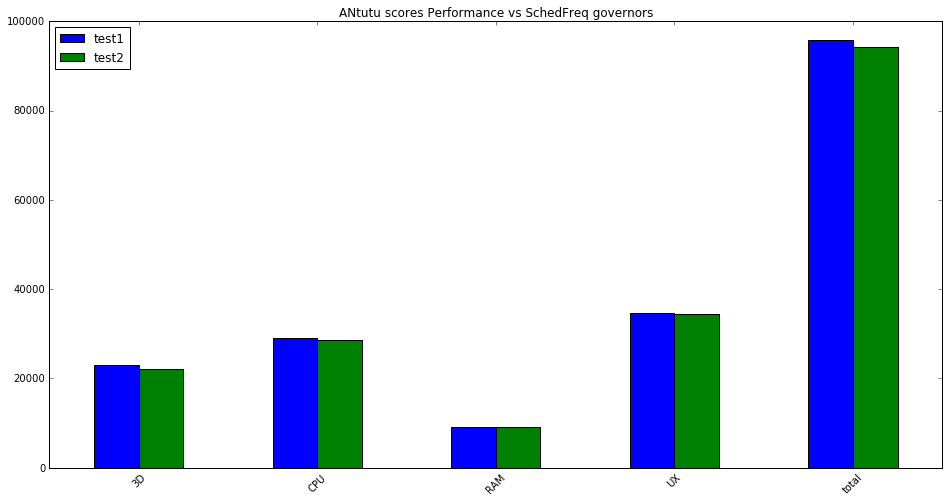

In [22]:
df.plot(kind='bar', rot=45, figsize=(16,8),
        title='ANtutu scores Performance vs SchedFreq governors');

In [15]:
map_label = {"00000000,000000f0": "big", "00000000,0000000f": "LITTLE"}
actor_order = ["GPU", "big", "LITTLE"]
runs = [("test1", os.path.join(te.res_dir, 'test1', 'trace.dat')), ("test2", os.path.join(te.res_dir, 'test2', 'trace.dat')), ("test3", os.path.join(te.res_dir, 'test3', 'trace.dat'))]

In [16]:
runs

[('test1',
  '/home/steven/lisa/lisa-github/results/20180507_164606/test1/trace.dat'),
 ('test2',
  '/home/steven/lisa/lisa-github/results/20180507_164606/test2/trace.dat'),
 ('test3',
  '/home/steven/lisa/lisa-github/results/20180507_164606/test3/trace.dat')]

In [17]:
# te.ftrace.get_trace(te.res_dir)
te.ftrace.report(os.path.join(te.res_dir, 'test1', 'trace.dat'), os.path.join(te.res_dir, 'test1', 'trace.txt'))
te.ftrace.report(os.path.join(te.res_dir, 'test2', 'trace.dat'), os.path.join(te.res_dir, 'test2', 'trace.txt'))
te.ftrace.report(os.path.join(te.res_dir, 'test3', 'trace.dat'), os.path.join(te.res_dir, 'test3', 'trace.txt'))

In [18]:
!tree {te.res_dir}

/home/steven/lisa/lisa-github/results/20180507_164606
├── screen.png
├── test1
│   ├── trace.dat
│   └── trace.txt
├── test2
│   ├── trace.dat
│   └── trace.txt
└── test3
    ├── trace.dat
    └── trace.txt

3 directories, 7 files


In [19]:
testresult_list

['/home/steven/lisa/lisa-github/results/20180507_164606/test1',
 '/home/steven/lisa/lisa-github/results/20180507_164606/test3',
 '/home/steven/lisa/lisa-github/results/20180507_164606/test2']

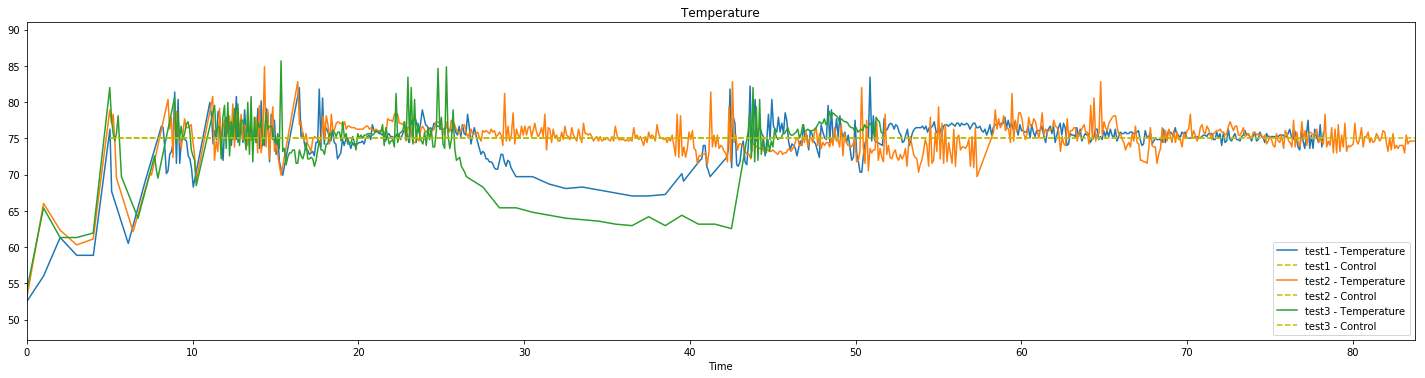

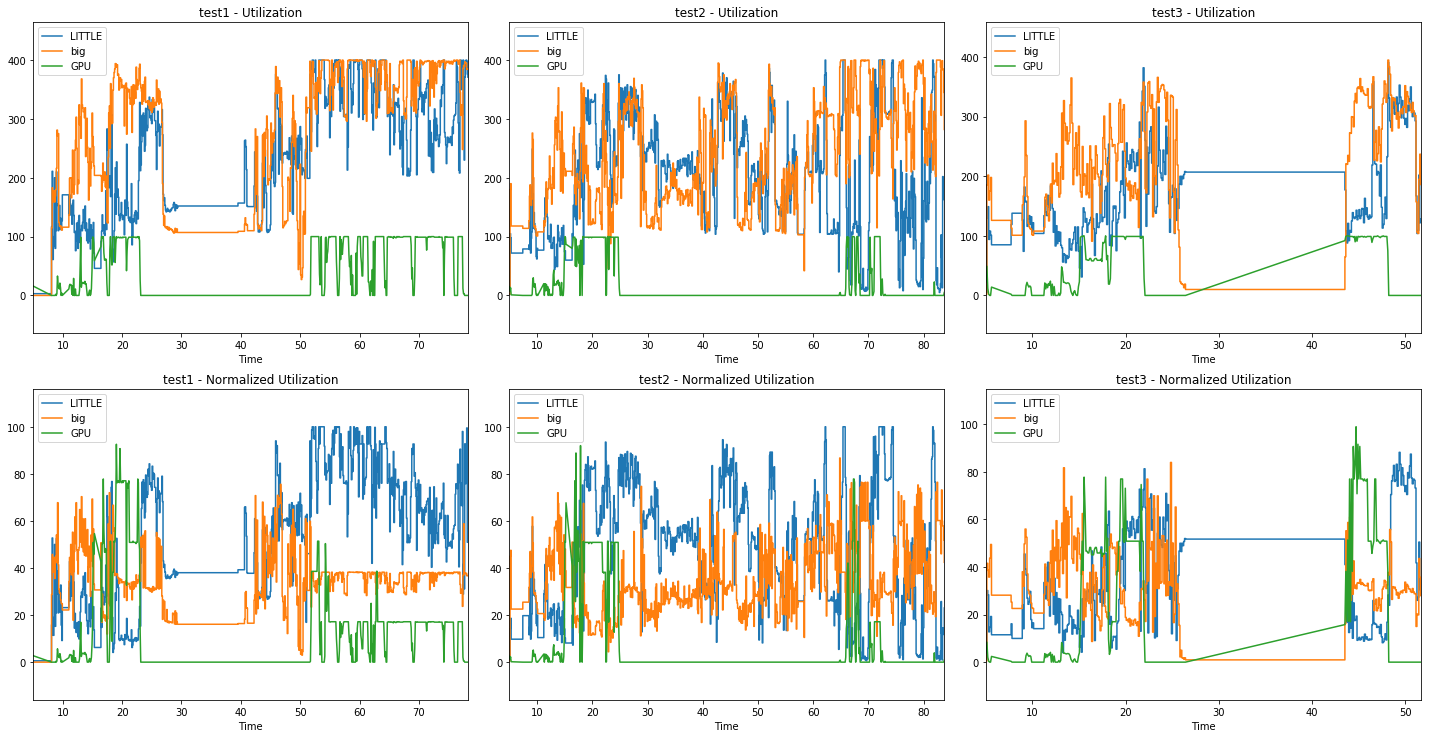

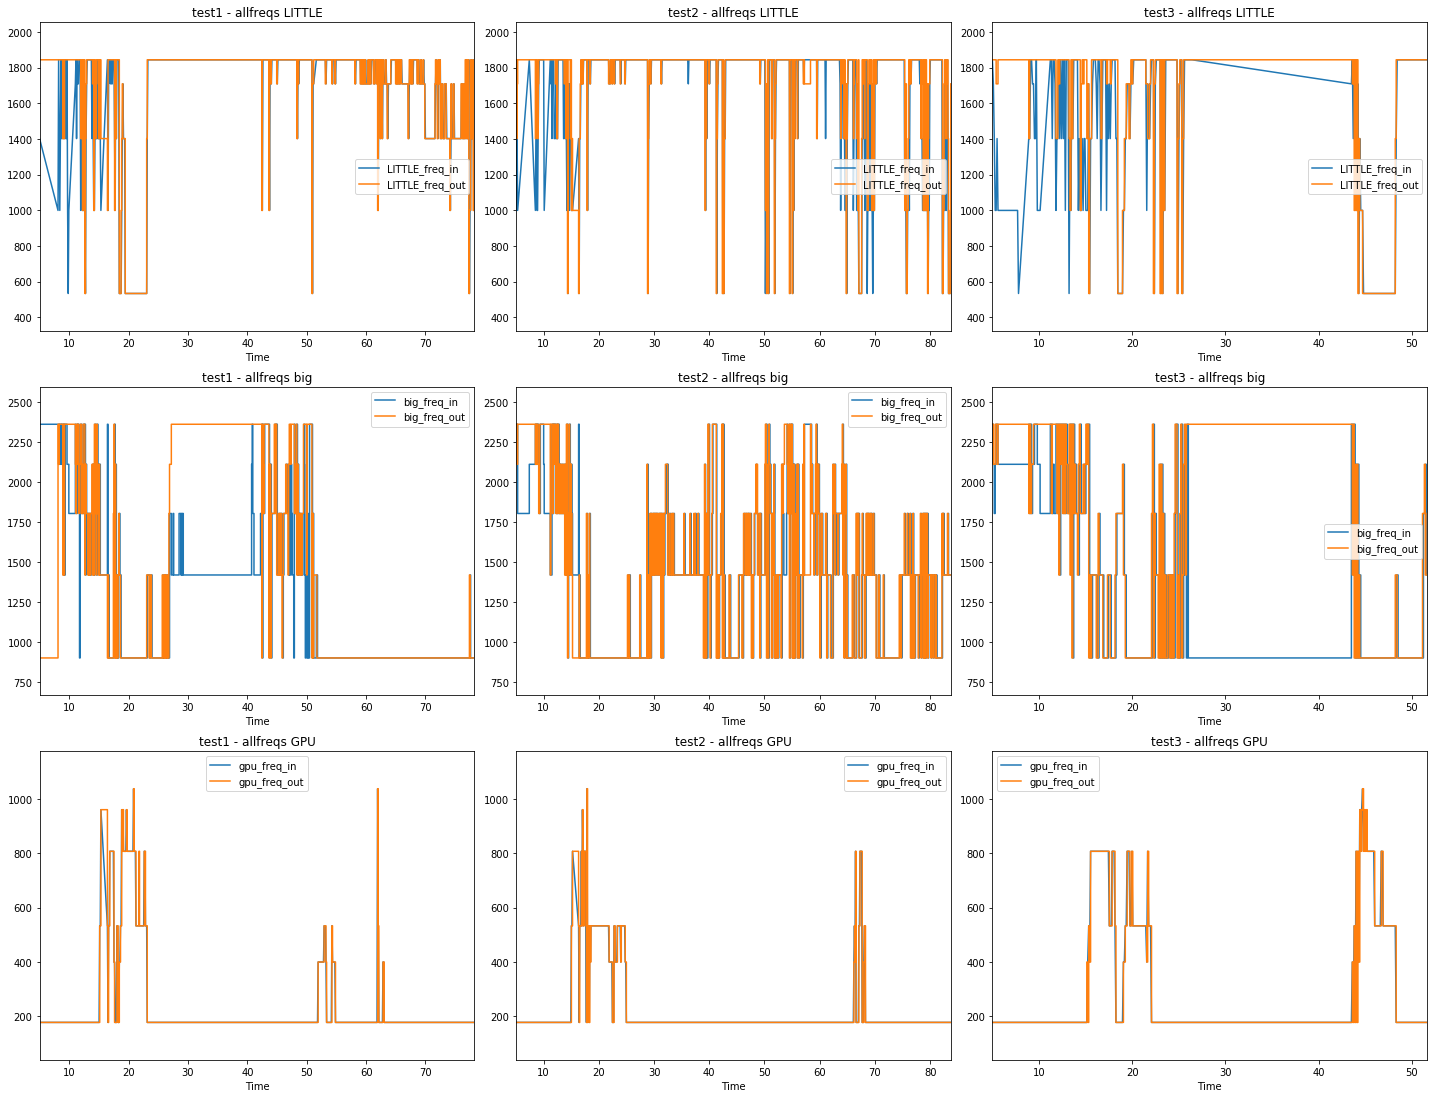

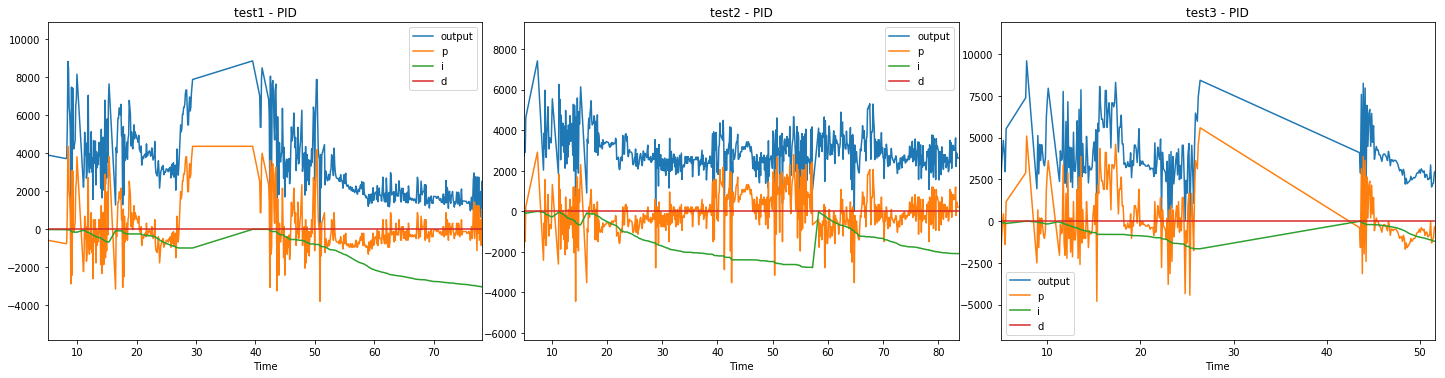

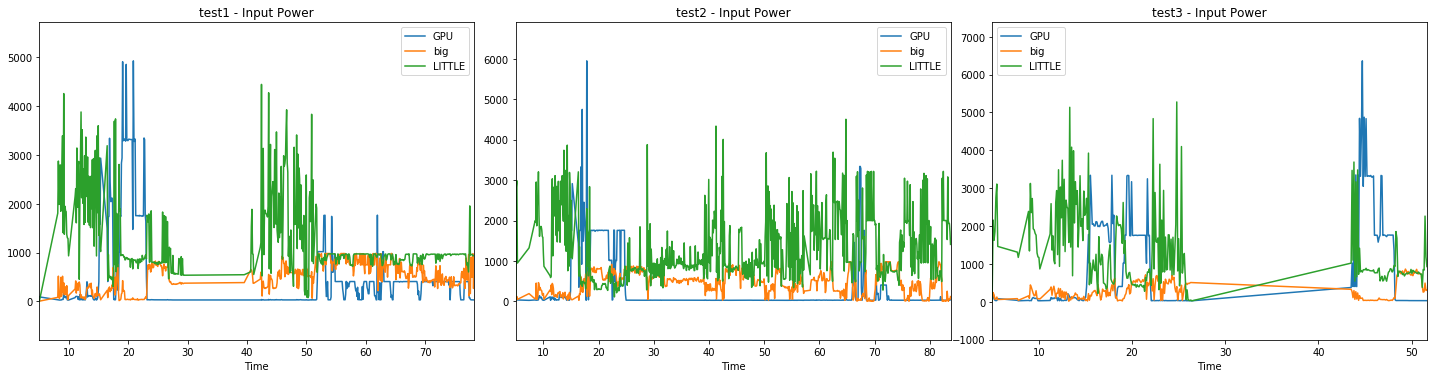

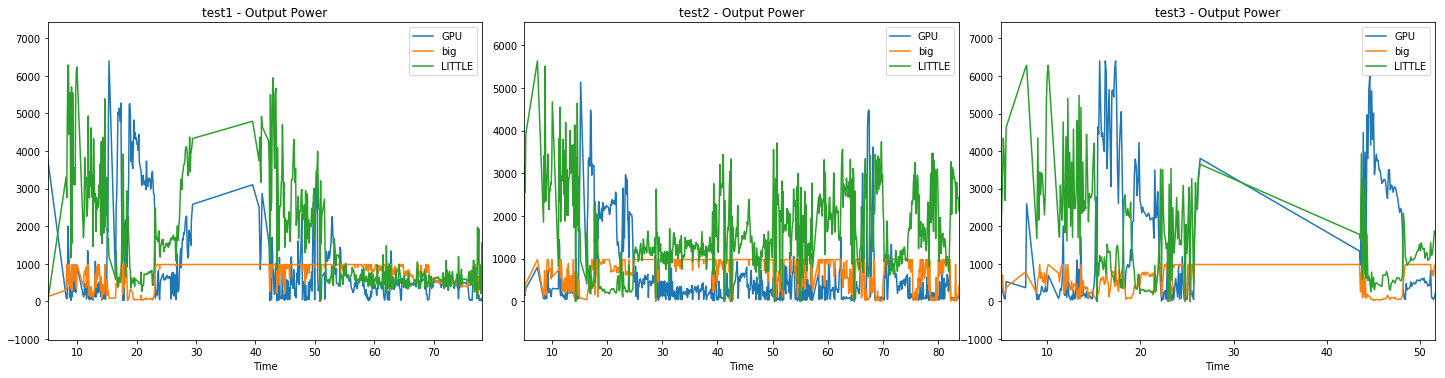

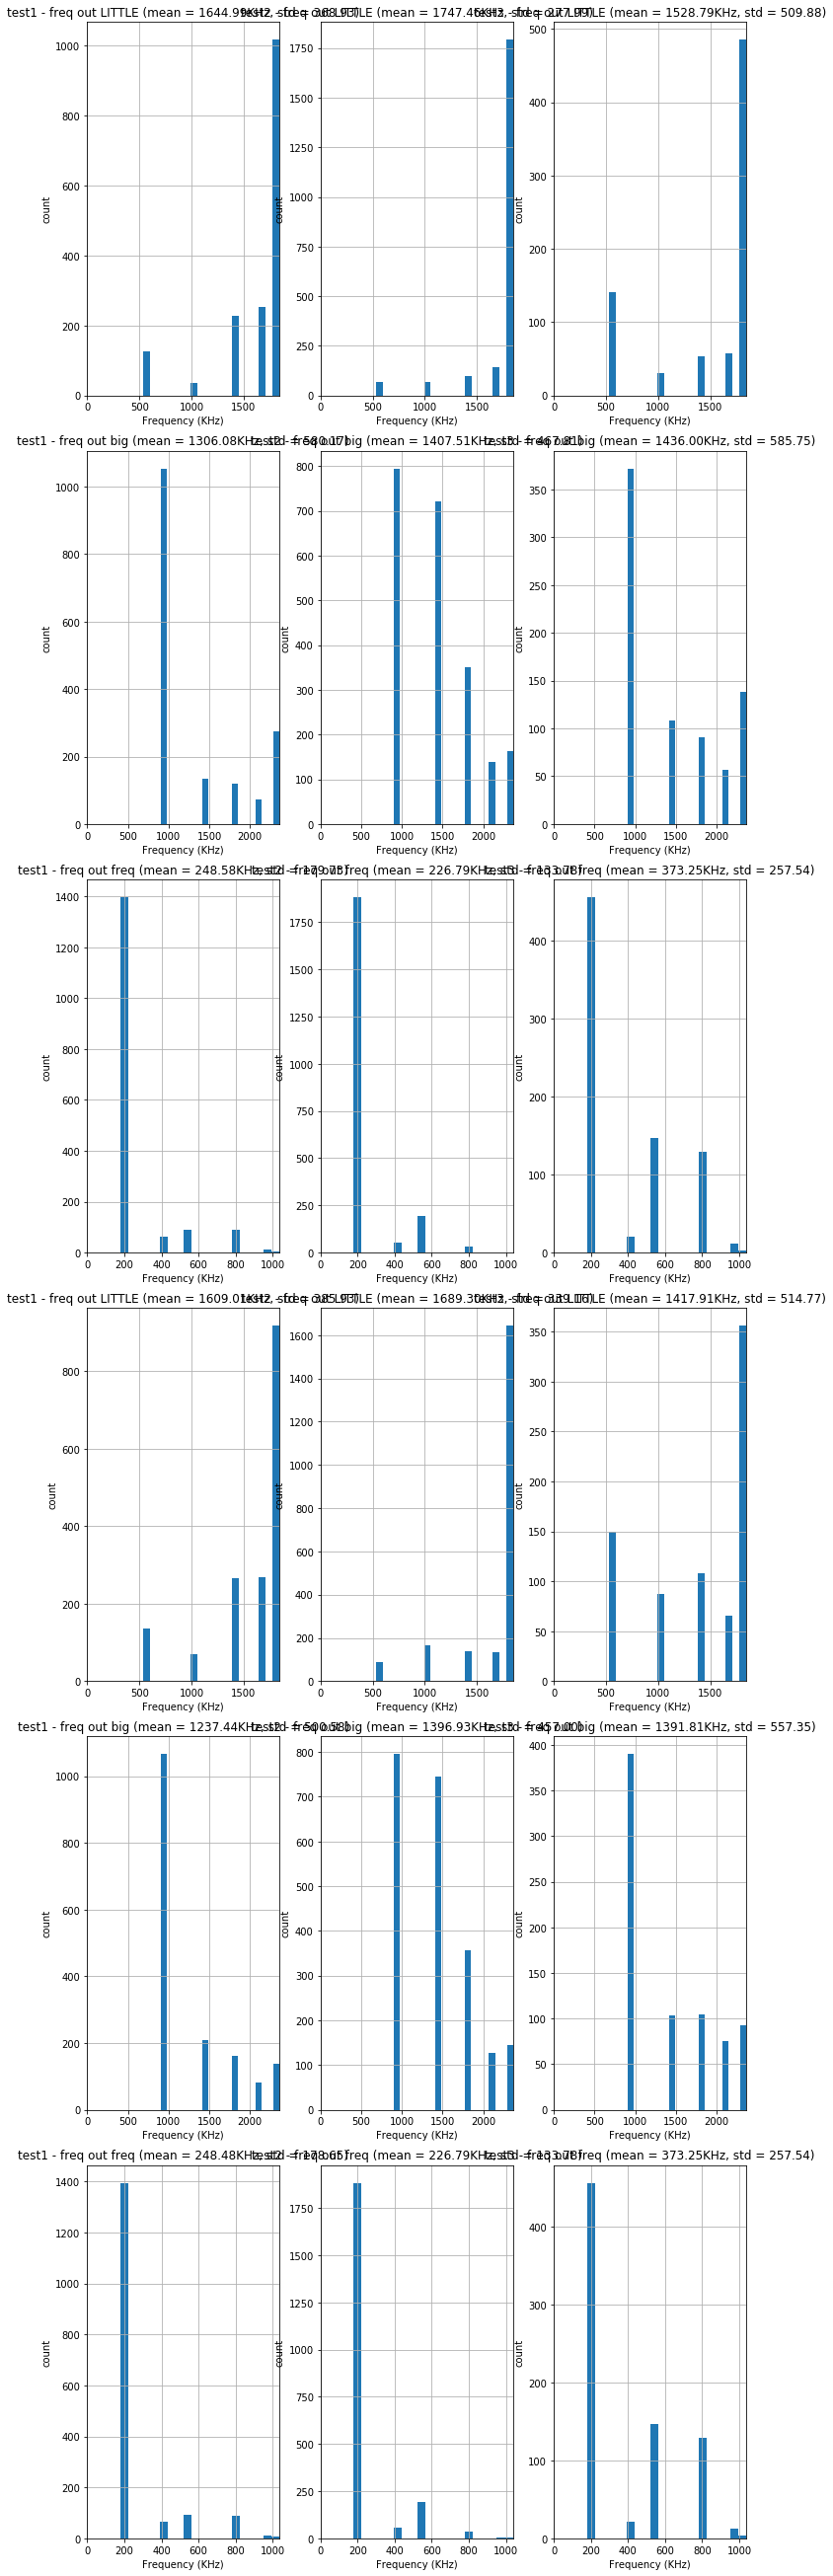

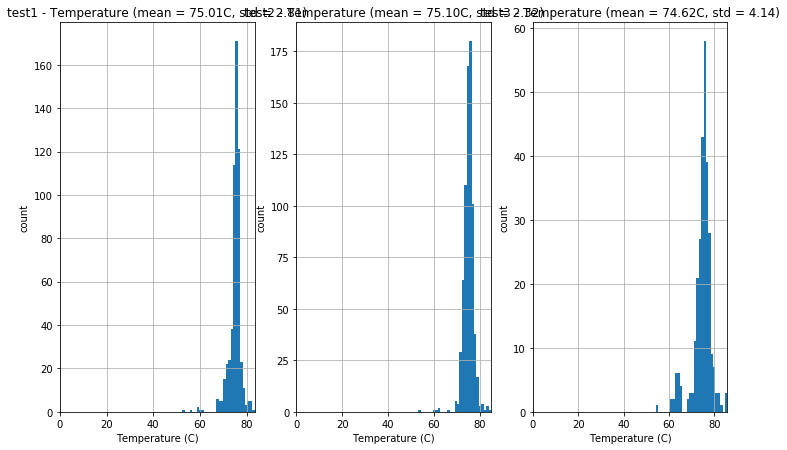

In [20]:
trappy.compare_runs(actor_order, map_label, runs)

In [53]:
ftrace1=trappy.FTrace(name='sustainable power', path=os.path.join(te.res_dir, 'test1', 'trace.dat'), scope="thermal")
ftrace2=trappy.FTrace(name='sustainable power', path=os.path.join(te.res_dir, 'test2', 'trace.dat'), scope="thermal")

In [60]:
ftrace.thermal_governor.data_frame
# trappy.plot_utils.plot_input_power([ftrace1, ftrace2],actor_order)
# trappy.ILinePlot(ftrace, signals=["cpu_in_power:power", "cpu_out_power:power"]).view()
# ftrace.cpu_out_power.data_frame['freq'].plot()

,__comm,__cpu,__line,__pid,current_temperature,delta_temperature,granted_power0,granted_power1,granted_power2,max_allocatable_power,power_range,req_power0,req_power1,req_power2,thermal_zone_id,total_granted_power,total_req_power
Time,,,,,,,,,,,,,,,,,
3.999744,kworker/4:1,4,28248,612,78325,-3325,595,332,2046,13700,2973,34,19,235,0,2973,288
4.100439,kworker/4:1,4,30435,612,86308,-11308,0,0,0,13749,0,44,401,5294,0,0,5739
4.199914,kworker/4:1,4,31784,612,74435,565,837,494,3533,13679,4865,105,62,886,0,4864,1053
4.299902,kworker/4:1,4,33593,612,77710,-2710,370,544,2200,13694,3113,212,312,2524,0,3114,3048
4.399920,kworker/4:1,4,34898,612,75459,-459,692,959,2468,13684,4119,244,338,1740,0,4119,2322
4.503867,kworker/4:1,4,36755,612,75459,-459,859,980,2274,13684,4115,237,475,1530,0,4113,2242
4.603894,kworker/4:1,4,38374,612,75049,-49,684,980,2635,13684,4299,126,411,1455,0,4299,1992
4.703961,kworker/4:1,4,40431,612,77096,-2096,173,815,2370,13694,3359,87,409,2379,0,3358,2875
4.803839,kworker/4:1,4,42237,612,74026,974,924,980,3271,13679,5176,144,323,1410,0,5175,1877


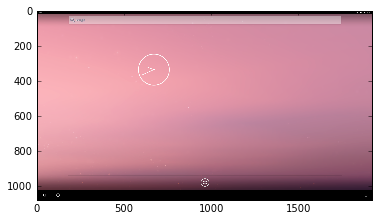

In [43]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img=mpimg.imread( os.path.join(te.res_dir, 'screen.png'))
imgplot = plt.imshow(img)



In [ ]:
target.execute('am force-stop com.antutu.ABenchMark')
target.execute('am force-stop com.antutu.benchmark.full')

In [27]:
from devlib.utils.android import ApkInfo

apk=ApkInfo(os.path.join(te.LISA_HOME, 'angry-birds-7-7-7.apk'))

In [28]:
apk.activity

'com.rovio.fusion.App'